# Linear Quantization

## Libraries

In [77]:
# pip install torch==2.1.1
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version in Torch: {torch.version.cuda}")
print(f"Device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA version in Torch: 13.0
Device: NVIDIA GeForce RTX 3060


In [78]:
def linear_q_with_scale_and_zero_point(
    tensor, scale, zero_point, dtype = torch.int8):
    scaled_and_shifted_tensor = tensor / scale + zero_point
    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)   
    return q_tensor

def linear_dequantization(quantized_tensor, scale, zero_point):
    return scale * (quantized_tensor.float() - zero_point)

def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()
    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = q_min - (r_min / scale)

    # Cut the zero point to fit within [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # Round and convert to integer
        zero_point = int(round(zero_point))
    
    return scale, zero_point

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """Plot a heatmap of tensors using seaborn"""
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """A method that plots 4 matrices, the original tensor, the quantized tensor the de-quantized tensor and the error tensor"""
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))
    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')
    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')
    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))
    fig.tight_layout()
    plt.show()
    
def quantization_error(tensor, dequantized_tensor):
    return (dequantized_tensor - tensor).abs().square().mean()

## Asymmetric linear quantization

Quantization with random `Scale` and `Zero Point`.
- Implement linear quantization for when the "scale" and "zero point" are known/randomly selected
- Maximum error: ≤ S/2
- PyTorch uses "round to the nearest 100% in case of a tie, away from zero"

In [79]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

# Random values
scale = 3.5
zero_point = -70

quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale, zero_point)
print(f'Quantized Tensor: \n {quantized_tensor}')

Quantized Tensor: 
 tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)


The correct approach is to convert the quantized tensor to FP32, as it is usually `int8` or `uint8`. Using `.float()` guarantees that the subtraction and multiplication by `scale` will occur in **FP32**. Result:
- continuous values
- no truncation
- correct dequantization

What usually happens when you don't convert:
- `quantized_tensor` → `int8`
- `zero_point` → `int`
- `(quantized_tensor - zero_point)` → `int`

If `scale` is float, PyTorch might promote the type, but the damage has already been done if there is:
- silent overflow
- dtype-dependent behavior
- larger-than-necessary error

It is not recommended to perform dequantization arithmetic directly on integers.

In [80]:
# no conversion to float
dequantized_tensor_int = scale * (quantized_tensor - zero_point)
print(f'Dequantized Tensor Int: \n {dequantized_tensor_int}')
print('\n')

dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)
print(f'Dequantized Tensor: \n {dequantized_tensor}')

Dequantized Tensor Int: 
 tensor([[ 192.5000,  -14.0000, -206.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000, -210.0000,  245.0000]])


Dequantized Tensor: 
 tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])


## Quantization Error

$$\boxed{\mathrm{MSE}=\frac{1}{N}\sum_{i=1}^{N}\left(\hat{x}_i - x_i\right)^2}$$

onde:
- $x_i$ = valor original (float)
- $\hat{x}_i$ = valor **dequantizado**
- $N$ = número total de elementos do tensor

Com quantização linear uniforme:

$$q_i=\operatorname{round}!\left(\frac{x_i}{s} + z\right)$$

Dequantização

$$\hat{x}_i = s , (q_i - z)$$

Substituindo na equação do MSE:

$$\boxed{\mathrm{MSE}\frac{1}{N}\sum_{i=1}^{N}\left[s\left(\operatorname{round}!\left(\frac{x_i}{s} + z\right) - z\right)x_i\right]^2}$$

Forma simplificada

Definindo o erro de quantização: $e_i = \hat{x}_i - x_i$ -> $\mathrm{MSE} = \mathbb{E}[e_i^2]$

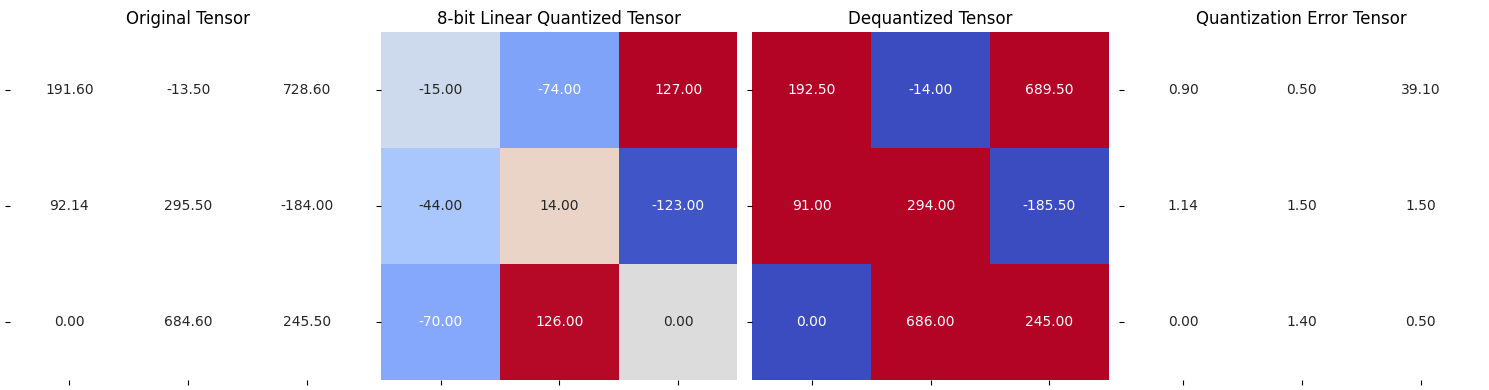

In [81]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

Calcule um erro de quantização "geral" usando a técnica de [Erro Quadrático Médio].

In [83]:
print(dequantized_tensor - test_tensor)
print('\n')

print((dequantized_tensor - test_tensor).square())
print('\n')

print(quantization_error(test_tensor, dequantized_tensor))

tensor([[  0.9000,  -0.5000, -39.1000],
        [ -1.1400,  -1.5000,  -1.5000],
        [  0.0000,   1.4000,  -0.5000]])


tensor([[8.0999e-01, 2.5000e-01, 1.5288e+03],
        [1.2996e+00, 2.2500e+00, 2.2500e+00],
        [0.0000e+00, 1.9601e+00, 2.5000e-01]])


tensor(170.8753)


**Why was the error high?**<br>
In the example above, we used random values ​​for the **Scale** and the **Zero Point**. The key to efficient quantization is to calculate these two parameters in a way that accurately maps the dynamic range (minimum and maximum) of your original tensor.

## Get Scale and Zero Point

In [84]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [85]:
print(q_min)
print(q_max)

r_min = test_tensor.min().item()
print(r_min)

r_max = test_tensor.max().item()
print(r_max)

scale = (r_max - r_min) / (q_max - q_min)
print(scale)

zero_point = q_min - (r_min / scale)
print(zero_point)

zero_point = int(round(zero_point))
print(zero_point)

new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)
print(new_scale)
print(new_zero_point)

-128
127
-184.0
728.5999755859375
3.578823433670343
-76.58645490333825
-77
3.578823433670343
-77


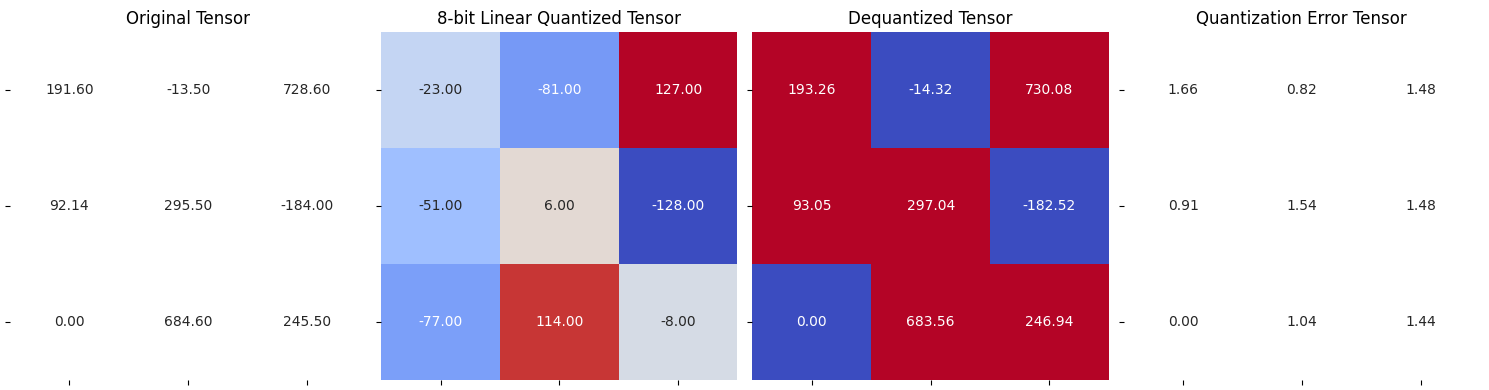

tensor(1.5730)


In [86]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, new_scale, new_zero_point)
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

x = (dequantized_tensor-test_tensor).square().mean()
print(x)

In [88]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor,dtype=dtype)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=dtype)
    return quantized_tensor, scale , zero_point

r_tensor = torch.randn((4, 4))
print(r_tensor)
print('\n')

quantized_tensor, scale, zero_point = linear_quantization(r_tensor)
print(quantized_tensor)
print('\n')

print(scale)
print(zero_point)

tensor([[ 1.9922, -1.3960,  0.3009,  0.9884],
        [-0.0759, -1.1904,  0.1258,  0.9549],
        [ 0.8393,  2.3186,  0.1098, -2.0737],
        [-1.8653,  0.3850,  1.3536,  1.5571]])


tensor([[ 108,  -89,    9,   49],
        [ -12,  -77,   -1,   47],
        [  41,  127,   -2, -128],
        [-116,   14,   71,   82]], dtype=torch.int8)


0.017224824194814643
-8


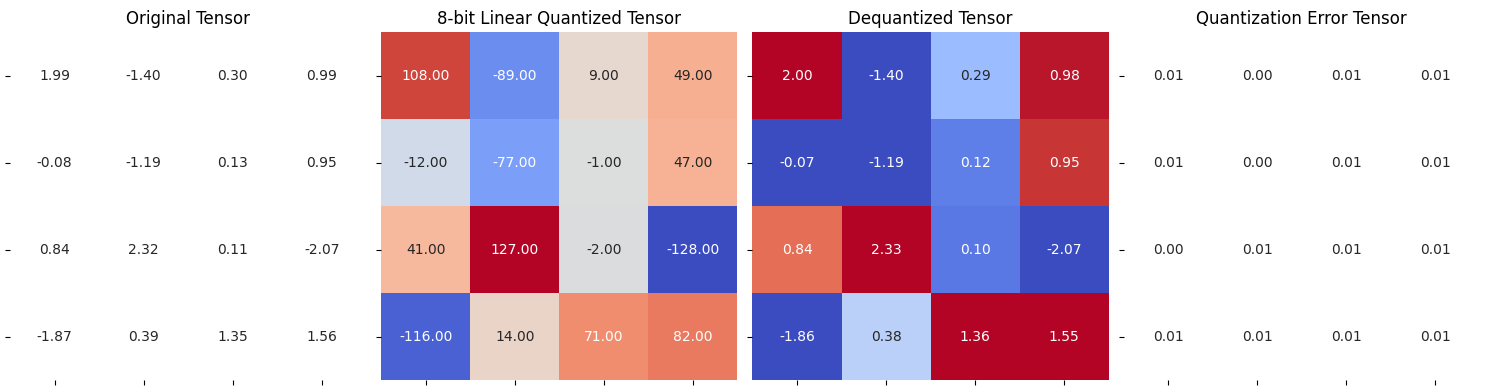

In [89]:
dequantized_tensor = linear_dequantization(quantized_tensor,scale, zero_point)
plot_quantization_errors(r_tensor, quantized_tensor, dequantized_tensor)

## Quantazation modes

### Symetric mode

In [90]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max
    # return the scale
    return r_max/q_max

def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale=scale, zero_point=0, dtype=dtype)
    return quantized_tensor, scale

### test the implementation on a 4x4 matrix
test_tensor = torch.randn((4, 4))
print(test_tensor)

tensor([[-3.1585e-01, -1.4367e+00, -3.1428e-04, -1.3871e+00],
        [ 3.9545e-01,  5.4606e-01, -1.0985e-01,  1.3645e+00],
        [-2.0033e+00, -3.0889e-01, -3.2215e-01, -4.9475e-01],
        [-8.6795e-01,  4.6763e-01, -1.9161e+00,  1.3760e+00]])


In [91]:
get_q_scale_symmetric(test_tensor)
quantized_tensor, scale = linear_q_symmetric(test_tensor)

Quantization Error : 2.031293661275413e-05


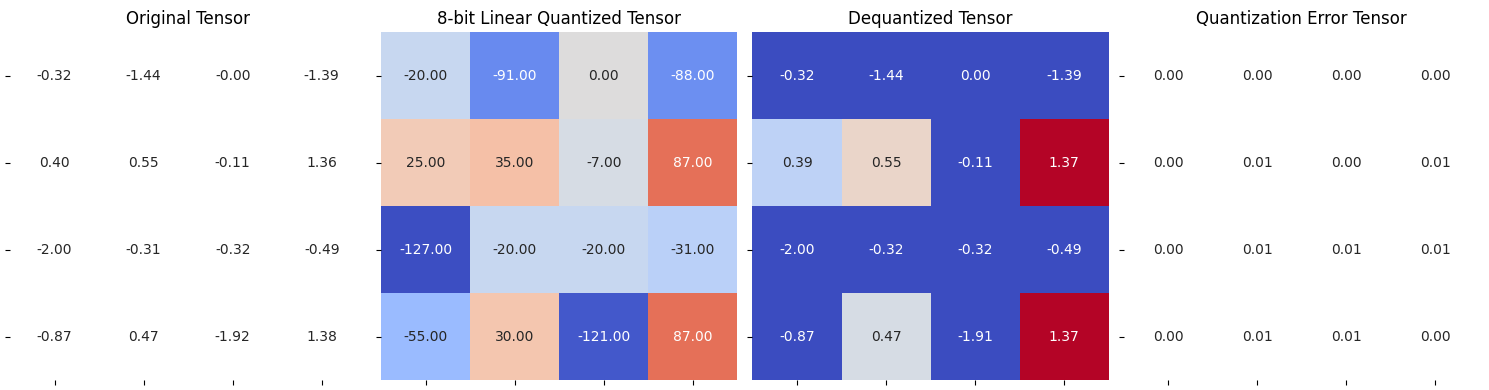

In [92]:
dequantized_tensor = linear_dequantization(quantized_tensor,scale,0)
print(f"""Quantization Error : {quantization_error(test_tensor, dequantized_tensor)}""")
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)


## Quantazation granularities

Quanto mais granular for a quantização, mais precisa ela será. No entanto, é importante observar que isso exige mais memória, já que precisamos armazenar mais parâmetros de quantização.

Existem diferentes níveis de granularidade quando falamos de quantização.

Temos a quantização por tensor, exatamente o que estavamos fazendo até agora mas, não somos obrigados a usar a mesma escala e o mesmo zero point para todo o tensor. Por exemplo, podemos calcular uma escala e um zero point para cada eixo. Isso é chamado de quantização por canal. Também podemos escolher grupos de $n$ elementos, calcular uma escala e um zero point para cada grupo, e quantizar cada grupo usando seus próprios parâmetros.

### PER TENSOR

**Quantização por Tensor**

- Ativações: Enquanto os pesos costumam ser quantizados por canal, as ativações (os dados que fluem entre as camadas) são quase sempre quantizadas por tensor. O principal motivo girar em torno do fato de que calcular estatísticas (min/max) para cada canal em tempo real durante a inferência é computacionalmente caro. A quantização por tensor permite que o hardware faça operações de produto escalar muito mais rápidas, já que a escala é constante para todo o cálculo daquela camada.
- Hardware Limitado ou Legado: Muitos aceleradores de IA (como NPUs de celulares mais antigos ou DSPs de baixo custo) não possuem suporte por hardware para múltiplas escalas dentro de uma mesma operação de matriz. Se estivermos desenvolvendo algo para um microcontrolador simples (TinyML), a quantização por tensor é, muitas vezes, a única opção suportada pelo compilador e pelo hardware.
- Eficiência de Memória e Banda: Como armazenamos apenas dois números ($S$ e $Z$) para milhões de parâmetros, o overhead de metadados é praticamente zero. Em modelos onde o gargalo não é a precisão, mas sim o tamanho final do arquivo ou a velocidade de transferência de dados, o per-tensor leva vantagem.

Obs.: O maior "inimigo" da quantização por tensor são os valores extremos. Imagine um tensor onde 99% dos valores estão entre -1 e 1, mas um único valor é 100. Na quantização por tensor, a escala terá que cobrir o intervalo até 100. Isso faz com que aqueles 99% dos valores (que são os mais importantes) fiquem "espremidos" em uma faixa muito pequena de bits, perdendo quase todos os seus detalhes e gerando muito ruído.

In [82]:
# test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [83]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [84]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

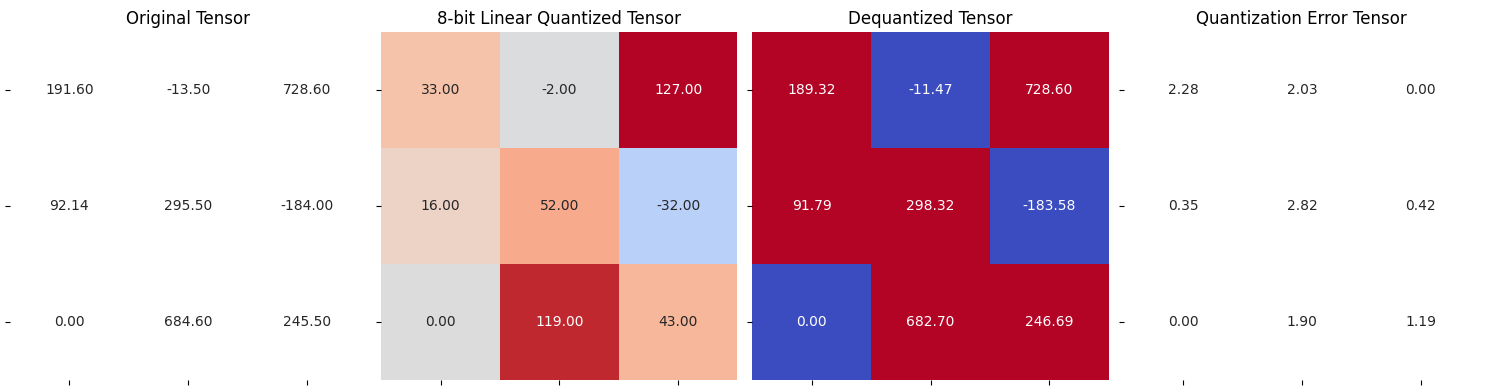

In [85]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [86]:
print(f"""Quantization Error : {quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.5091912746429443


### PER CHANNEL

**Quantização por Canal**

Nesse cenário, calculamos parâmetros ($S$ e $Z$) para cada canal de saída (ou cada neurônio). Casos de uso principais:
- Pesos de Camadas Convolucionais: Em redes neurais, diferentes filtros em uma camada convolucional costumam ter faixas dinâmicas (valores mínimos e máximos) drasticamente diferentes. Se você usar uma escala única para o tensor inteiro, um filtro com valores altos pode "esmagar" a precisão de um filtro com valores pequenos.
- Mitigação de Outliers: Se um único canal possui valores muito discrepantes, a quantização por canal isola esse impacto. Na quantização por tensor (per-tensor), esse outlier forçaria uma escala muito larga para todos, fazendo com que canais "normais" perdessem quase toda a informação.
- Modelos de Visão Computacional (CNNs): Modelos como ResNet ou EfficientNet quase sempre exigem quantização por canal para manter a acurácia próxima ao modelo original (FP32).

Implement Per Channel Symmetric Quantization
dim parameter decides if it needs to be along the rows or columns
- dim = 0, along the rows
- dim = 1, along the columns

Iterate through each row to calculate its scale.

In [ ]:
def linear_q_symmetric_per_channel(tensor,dim,dtype=torch.int8):
    return quantized_tensor, scale

In [4]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [6]:
dim = 0
output_dim = test_tensor.shape[dim]
output_dim

3

In [8]:
scale = torch.zeros(output_dim)
scale

tensor([0., 0., 0.])

In [16]:
for index in range(output_dim):
    sub_tensor = test_tensor.select(dim,index)
    # print(sub_tensor)
    scale[index] = get_q_scale_symmetric(sub_tensor)

NameError: name 'get_q_scale_symmetric' is not defined

In [9]:
scale

tensor([0., 0., 0.])

In [11]:
scale_shape = [1] * test_tensor.dim()
scale_shape

[1, 1]

In [13]:
scale_shape[dim] = -1
scale_shape

[-1, 1]

In [15]:
scale = scale.view(scale_shape)
copy_scale = scale
scale

tensor([[0.],
        [0.],
        [0.]])

Entendendo tensores por divisão de tensores usando a função de visualização

In [18]:
m = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [36]:
s = torch.tensor([1,5,10])
print(s)
print(s.shape)
print(s.view(1, 3).shape)
print(s.view(1, -1).shape) # alternate way
print(s.view(-1, 1).shape)

tensor([ 1,  5, 10])
torch.Size([3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([3, 1])


Ao longo da divisão da linha

In [31]:
scale = torch.tensor([[1], [5], [10]])
print(scale.shape)
print(m / scale)

torch.Size([3, 1])
tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]])


Ao longo da divisão da coluna

In [32]:
scale = torch.tensor([[1, 5, 10]])
print(scale.shape)
print(m / scale)

torch.Size([1, 3])
tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]])


Voltando à quantização do tensor

In [33]:
scale = copy_scale
print(scale)
print(scale.shape)

tensor([[0.],
        [0.],
        [0.]])
torch.Size([3, 1])


In [35]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale=scale, zero_point=0)
quantized_tensor

tensor([[ 127, -128,  127],
        [ 127,  127, -128],
        [   0,  127,  127]], dtype=torch.int8)

Agora, coloque tudo isso na função linear_q_symmetric_per_channel definida anteriormente.

In [ ]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)

    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)
   
    return quantized_tensor, scale

In [ ]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [ ]:
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(
    test_tensor, dim=0)

### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(
    test_tensor, dim=1)

In [ ]:
dequantized_tensor_0 = linear_dequantization(
    quantized_tensor_0, scale_0, 0)

plot_quantization_errors(
    test_tensor, quantized_tensor_0, dequantized_tensor_0)

In [ ]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_0)}""")

In [ ]:
dequantized_tensor_1 = linear_dequantization(quantized_tensor_1, scale_1, 0)

plot_quantization_errors(test_tensor, quantized_tensor_1, dequantized_tensor_1, n_bits=8)

print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_1)}""")

### PER GROUP

**Quantização por Grupo**

Aqui, dividimos os dados em blocos sequenciais (ex: grupos de 32, 64 ou 128 elementos) dentro de uma dimensão. Casos de uso principais:
- Large Language Models (LLMs): Modelos como Llama ou Mistral utilizam essa técnica (ex: formatos GGUF ou AWQ). Como esses modelos são gigantescos, eles apresentam fenômenos chamados "emergent features" — canais específicos que têm picos de ativação imensos. A quantização por grupo permite lidar com essa instabilidade sem o custo absurdo de ter um parâmetro para cada elemento.
- Quantização de Extrema Baixa Precisão (4-bit ou menos): Quando você desce para 4 bits, o erro de quantização é inerentemente alto. Usar grupos pequenos (ex: bloco de 32 elementos) ajuda a "corrigir o curso" da escala frequentemente, mantendo o erro sob controle.
- Hardware com Limitação de Banda de Memória: Embora exija mais memória que a por canal, a quantização por grupo é muito eficiente em GPUs modernas, pois os parâmetros de escala podem ser carregados no cache junto com os dados do grupo, acelerando o processamento.

## Inferência com Quantização Linear (W8A32)

Nesta etapa, vamos focar em como realizar a inferência utilizando a quantização linear. Como vimos anteriormente, em uma rede neural, você pode quantizar tanto os pesos quanto as ativações, mas o impacto no hardware depende do que exatamente foi quantizado.

**Pesos vs. Ativações**

- **Apenas Pesos (W8A32):** Se você quantizar apenas os pesos, a computação ainda utilizará aritmética de ponto flutuante (,  ou ). Nesse caso, os pesos precisam ser **dequantizados** para o formato original antes do cálculo.
- **Pesos e Ativações (W8A8):** Se ambos forem quantizados, a computação utiliza aritmética baseada em **inteiros**. Isso é mais eficiente, porém não é suportado por todos os hardwares.

**Implementando uma Camada Linear Quantizada**

Vamos implementar uma função em Python (utilizando PyTorch) para uma camada linear sem viés (*bias*), onde os pesos estão em 8 bits e a entrada (ativação) permanece em 32 bits.

#### A Função: `quantized_linear_without_bias`

A lógica consiste em transformar os pesos inteiros de volta para ponto flutuante antes de realizar a operação de matriz. A fórmula de dequantização utilizada é:



*(Onde  é a escala e  é o ponto zero)*.

```python
import torch

def quantized_linear_without_bias(input, q_w, scale, zero_point):
    # Garante que a entrada seja float32 e os pesos sejam int8
    # q_w: pesos quantizados (torch.int8)
    
    # 1. Dequantização dos pesos
    dequantized_weights = q_w.to(torch.float32)
    dequantized_weights = (dequantized_weights - zero_point) * scale
    
    # 2. Operação Linear (Produto escalar)
    output = torch.nn.functional.linear(input, dequantized_weights)
    
    return output

```

---

### Exemplo Prático e Comparação

Para validar a função, comparamos o resultado da camada quantizada com o resultado de uma camada comum em .

1. **Preparação:** Definimos os dados de entrada e os pesos originais.
2. **Quantização:** Aplicamos a quantização linear simétrica nos pesos para obter `q_w` e `scale`.
3. **Execução:**
* Chamamos `quantized_linear_without_bias` com o ponto zero igual a .
* Chamamos a função linear padrão do PyTorch com os pesos originais.



**Resultado:**
Ao comparar os dois outputs, notamos que os valores são extremamente próximos. Isso demonstra que a quantização de 8 bits preserva a precisão necessária para o modelo funcionar corretamente, reduzindo drasticamente o espaço de armazenamento dos pesos.

---
- W8A32 significa pesos em 8 bits e ativações em 32 bits.
- Para simplificar, a camada linear não terá viés.

In [ ]:
def quantized_linear_W8A32_without_bias(input, q_w, s_w, z_w):
    assert input.dtype == torch.float32
    assert q_w.dtype == torch.int8

    dequantized_weight = q_w.to(torch.float32) * s_w + z_w
    output = torch.nn.functional.linear(input, dequantized_weight)
    
    return output

In [ ]:
input = torch.tensor([1, 2, 3], dtype=torch.float32)

weight = torch.tensor([
    [-2,   -1.13, 0.42],
    [-1.51, 0.25, 1.62],
    [0.23,  1.35, 2.15]])

q_w, s_w  = linear_q_symmetric(weight)
q_w
s_w

output = quantized_linear_W8A32_without_bias(input, q_w, s_w, 0)
print(f"This is the W8A32 output: {output}")
fp32_output = torch.nn.functional.linear(input, weight)
print(f"This is the output if we don't quantize: {fp32_output}")

## Building your own Quantizer: Custom Build an 8-Bit Quantizer

Crie a classe de destino, `W8A16LinearLayer()`, que será responsável por quantizar seu modelo.

##### 1.1 - `w8_a16_forward` Function

```Python
W8A16LinearLayer
                    # 8-bit  # 16-bit         # optional
* w8_a16_forward -> weights, input,   scales, bias=None
                    
```

- Cast the 8-bit `weights` to the same data type as the `input`, "casted weights",
- keeping the "casted weights" in the same range as before, [-128, 127]
- Next, $$(({inputs} \cdot \text{``casted weights''}) * {scale}) + {bias}$$ 

In [ ]:
random_int8 = torch.randint(-128, 127, (32, 16)).to(torch.int8)
random_hs = torch.randn((1, 16), dtype=torch.bfloat16)
scales = torch.randn((1, 32), dtype=torch.bfloat16)
bias = torch.randn((1, 32), dtype=torch.bfloat16)

**Note:** Since the values are random, what you see in the video might be different than what you will get.

In [ ]:
F.linear(random_hs, random_int8.to(random_hs.dtype))

In [ ]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales

In [ ]:
(F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales) + bias

- Implement all this as a function, `w8_a16_forward`

In [ ]:
def w8_a16_forward(weight, input, scales, bias=None):
    
    casted_weights = weight.to(input.dtype)
    output = F.linear(input, casted_weights) * scales
    
    if bias is not None:
        output = output + bias
      
    return output

In [ ]:
print("With bias:\n\n", 
      w8_a16_forward(random_int8, random_hs, scales, bias))

print("\nWithout bias:\n\n", 
      w8_a16_forward(random_int8, random_hs, scales))

### 1.2 - `init` Function of class `W8A16LinearLayer`

- This is how the `init` is of [PyTorch Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear):
```Python
def __init__(self, in_features, out_features, bias=True,
             device=None, dtype=None)

```

In [ ]:
### running this will result in an error
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        self.int8_weights = nn.Parameter(torch.Tensor([0, 1]
                                     ).to(dtype=torch.int8))

try:
    
    W8A16LinearLayer(1, 1)
    
except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

In [ ]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

- Test your implementation.

In [ ]:
dummy_instance = W8A16LinearLayer(16, 32)

In [ ]:
print(dummy_instance.int8_weights.shape)
print(dummy_instance.scales.shape)

### 1.3 - `forward` Function of class `W8A16LinearLayer`

- Use the `w8_a16_forward` defined earlier (Step 1.1) to define the `forward` function.

In [ ]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

    def forward(self, input):
        return w8_a16_forward(self.int8_weights, 
                              input, self.scales, self.bias)

In [ ]:
module = W8A16LinearLayer(16, 32)
dummy_hidden_states = torch.randn(1, 6, 16)
module(dummy_hidden_states).shape
module(dummy_hidden_states).dtype

### 1.4 - `quantize` Function of class `W8A16LinearLayer`

- `quantize` function will dynamically quantize half-precision weights into `torch.int8`

In [ ]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

    def quantize(self, weights):
        w_fp32 = weights.clone().to(torch.float32)

        scales = w_fp32.abs().max(dim=-1).values / 127
        scales = scales.to(weights.dtype)

        int8_weights = torch.round(weights
                        /scales.unsqueeze(1)).to(torch.int8)

        self.int8_weights = int8_weights
        self.scales = scales
    
    def forward(self, input):
        return w8_a16_forward(self.int8_weights, 
                              input, self.scales, self.bias)      

In [ ]:
module = W8A16LinearLayer(4, 8)
print("Weights before:\n" , module.int8_weights)
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)
module.quantize(random_matrix)
print("Weights After:\n" , module.int8_weights)
module.scales
module.scales.shape
module.int8_weights.shape
### dequantized weights
module.int8_weights * module.scales.unsqueeze(1)
### original weights
random_matrix
(random_matrix - module.int8_weights * module.scales.unsqueeze(1)).abs().mean()

## Baseline

## Competitor

- Goal: Convert FP32 CNNs into INT8 without significant accuracy loss
- Why: INT8 math has higher throughput, and lower memory requirements
- Challenge: INT8 has significantly lower precision and dynamic range than FP32
- Solution: Minimize loss of information when quantizing trained model weights to INT8 and during INT8 computation of activations
- Result: Method was implemented in TensorRT. It does not require any additional fine tuning or retraining

INT8 has significantly lower precision and dynamic range compared to FP32 and requires more than a simple type conversion from FP32 to INT8.

## Extra

### Linear Interpolation Approach

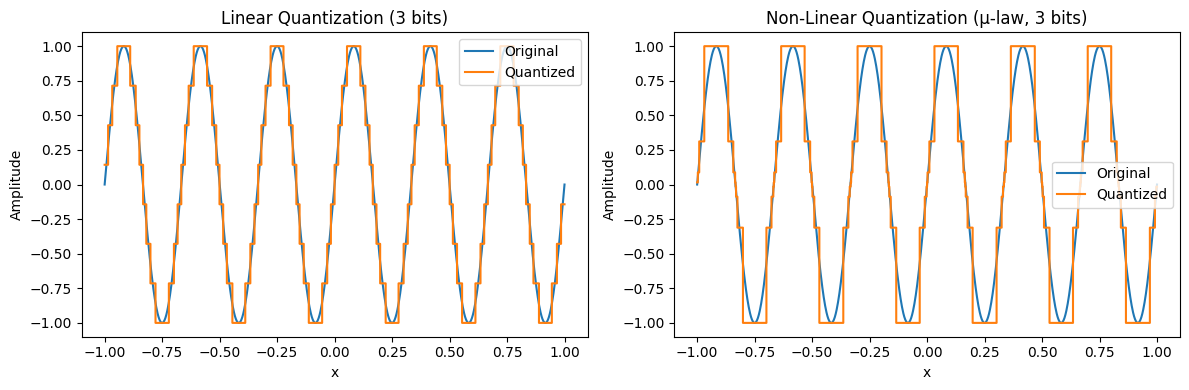

In [ ]:
x = np.linspace(-1, 1, 1000)
signal = np.sin(2 * np.pi * 3 * x)

def linear_quantize(signal, bits=3):
    levels = 2 ** bits
    min_val, max_val = -1.0, 1.0
    step = (max_val - min_val) / (levels - 1)
    q = np.round((signal - min_val) / step) * step + min_val
    return q

linear_q = linear_quantize(signal, bits=3)

def mu_law_quantize(signal, mu=50, bits=3):
    compressed = np.sign(signal) * np.log1p(mu * np.abs(signal)) / np.log1p(mu)
    levels = 2 ** bits
    step = 2 / (levels - 1)
    q_comp = np.round((compressed + 1) / step) * step - 1
    expanded = np.sign(q_comp) * (1 / mu) * ((1 + mu) ** np.abs(q_comp) - 1)
    return expanded

nonlinear_q = mu_law_quantize(signal, mu=50, bits=3)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x, signal, label="Original")
plt.step(x, linear_q, where="mid", label="Quantized")
plt.title("Linear Quantization (3 bits)")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, signal, label="Original")
plt.step(x, nonlinear_q, where="mid", label="Quantized")
plt.title("Non-Linear Quantization (μ-law, 3 bits)")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

### Classic DSP Approach

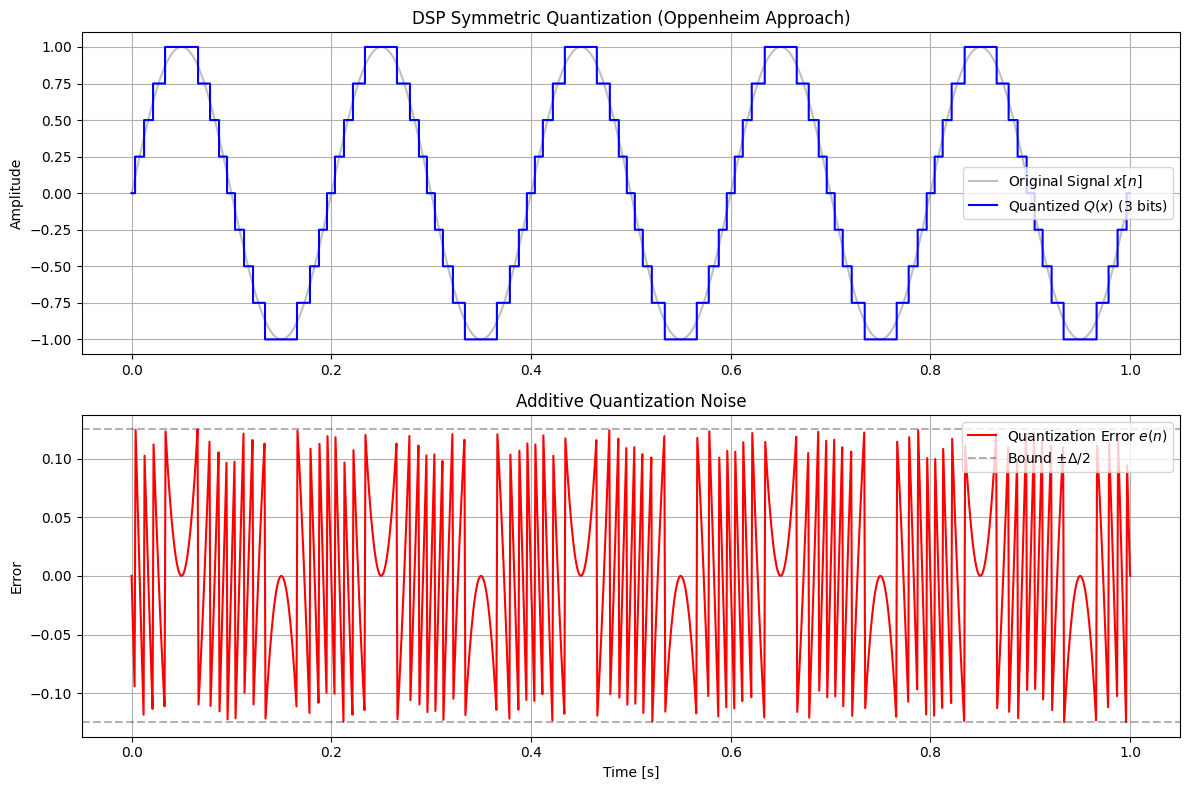

In [88]:
import numpy as np
import matplotlib.pyplot as plt

fs = 1000
t = np.linspace(0, 1, fs)
x_m = 1.0
b = 3
levels = 2**b

x_n = x_m * np.sin(2 * np.pi * 5 * t)
delta = (2 * x_m) / (2**b) 
x_q = delta * np.floor(x_n / delta + 0.5)
e_n = x_q - x_n

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, x_n, label=r"Original Signal $x[n]$", color='gray', alpha=0.5)
plt.step(t, x_q, label=f"Quantized $Q(x)$ ({b} bits)", where='mid', color='blue')
plt.title("DSP Symmetric Quantization (Oppenheim Approach)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, e_n, label=r"Quantization Error $e(n)$", color='red')
plt.axhline(y=delta/2, color='black', linestyle='--', alpha=0.3, label=r"Bound $\pm\Delta/2$")
plt.axhline(y=-delta/2, color='black', linestyle='--', alpha=0.3)
plt.title("Additive Quantization Noise")
plt.xlabel("Time [s]")
plt.ylabel("Error")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()